In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from src.functions import lmb_opt, lmb_opt_group, find_best_features_subset, find_best_group_subset
from src.plot_functions import score, plot_scores

# Metadata

In [2]:
BUDGET = 60
TOTAL_COST = 60

# Load data

### Subset with Your dataset

In [3]:
cancer = load_breast_cancer()
X = cancer['data']
y = cancer['target']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
cancer['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [7]:
groups_df = pd.DataFrame({
    'feature': cancer['feature_names'],
    'costs': [10]*5+[10]*5+[10]*5+[10]*5+[9]*5+[8]*5,
    'group_id': [0]*5+[1]*5+[2]*5+[3]*5+[5]*5+[5]*5,
    'feature_id': [i for i in range(30)]
})
groups_df

,feature,costs,group_id,feature_id
0,mean radius,10,0,0
1,mean texture,10,0,1
2,mean perimeter,10,0,2
3,mean area,10,0,3
4,mean smoothness,10,0,4
5,mean compactness,10,1,5
6,mean concavity,10,1,6
7,mean concave points,10,1,7
8,mean symmetry,10,1,8
9,mean fractal dimension,10,1,9


In [8]:
group_costs = {}
for i,j in zip(groups_df['group_id'], groups_df['costs']):
    if i not in group_costs:
        group_costs[i] = j

normalized_costs = {}
min_cost = min(group_costs.values())
max_cost = max(group_costs.values())
for k,v in group_costs.items():
    normalized_costs[k] = (1 - 0.1) * (v - min_cost) / (max_cost - min_cost) + 0.1

groups = {}
for i,j in zip(groups_df['group_id'], groups_df['feature_id']):
    if i not in groups:
        groups[i] = [j]
    else:
        groups[i].append(j)

features_dict = {}
for i,j in zip(groups_df['feature_id'], groups_df['feature']):
    features_dict[i] = j


l_opt = 0.21224175566366077
l_opt_group = 4.198612604606511

if l_opt is None:
    l_opt = lmb_opt(X=X_train, y=y_train, groups=groups, group_costs=group_costs, normalized_costs=normalized_costs, budget=20, n=10, m=10000)
if l_opt_group is None:
    l_opt_group = lmb_opt_group(X=X_train, y=y_train, groups=groups, group_costs=group_costs, normalized_costs=normalized_costs, budget=20, n=10, m=5000)

print(l_opt)
print(l_opt_group)

0.21224175566366077
4.198612604606511


# Feature selection

### Traditional

In [9]:
features_trad_a1, costs_trad_a1 = find_best_features_subset(
    X_train,
    y_train,
    groups,
    group_costs,
    budget=BUDGET
)
df_traditional = pd.DataFrame({
        'feature_order' : features_trad_a1,
        'total_cost': costs_trad_a1
    })

Num of features:  1
Total cost     :  10
Num of features:  2
Total cost     :  20
Num of features:  7
Total cost     :  30
Num of features:  15
Total cost     :  40
Num of features:  16
Total cost     :  49


### Cost-constrained (CC-SFS)

In [10]:
features_cs_sfs, costs_cs_sfs = find_best_features_subset(
    X_train,
    y_train,
    groups,
    group_costs,
    budget=BUDGET,
    lmb=l_opt
)
df_cc_sfs = pd.DataFrame({
        'feature_order' : features_cs_sfs,
        'total_cost': costs_cs_sfs
    })

Num of features:  1
Total cost     :  9
Num of features:  11
Total cost     :  19
Num of features:  16
Total cost     :  29
Num of features:  21
Total cost     :  39
Num of features:  26
Total cost     :  49


### Cost-constrained (CC-GFS)

In [11]:
TAU = 0.8
features_cs_gfs, costs_cs_gfs = find_best_group_subset(
    X_train,
    y_train,
    groups,
    group_costs,
    budget=BUDGET,
    tau=TAU,
    lmb=l_opt_group
)
df_cc_gfs = pd.DataFrame({
    'feature_order' : features_cs_gfs,
    'total_cost': costs_cs_gfs
})


Num of f, c :  1 ,  1
Total cost  :  9
Num of f, c :  2 ,  2
Total cost  :  9
Num of f, c :  2 ,  2
Total cost  :  19
Num of f, c :  3 ,  3
Total cost  :  29
Num of f, c :  3 ,  3
Total cost  :  39


# Results

### Plot settings

In [12]:
dict_desc_names = {
    'traditional' : 'Traditional',
    'cc_sfs' : 'CC-SFS',
    'cc_gfs' : 'CC-GFS'
}

dict_colors = {
    'traditional' : 'red',
    'cc_sfs' : 'blue',
    'cc_gfs' : 'green'
}

dict_linestyle = {
    'traditional' : 'solid',
    'cc_sfs' : 'dashed',
    'cc_gfs' : 'dashed'
}

plot_settings = {}
plot_settings['names'] = dict_desc_names
plot_settings['colors'] = dict_colors
plot_settings['linestyles'] = dict_linestyle
plot_settings

{'names': {'traditional': 'Traditional',
  'cc_sfs': 'CC-SFS',
  'cc_gfs': 'CC-GFS'},
 'colors': {'traditional': 'red', 'cc_sfs': 'blue', 'cc_gfs': 'green'},
 'linestyles': {'traditional': 'solid',
  'cc_sfs': 'dashed',
  'cc_gfs': 'dashed'}}

### Scoring

In [13]:
scores = {}
scores['traditional'] = score(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    feature_order = df_traditional['feature_order']
)
scores['cc_sfs'] = score(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    feature_order = df_cc_sfs['feature_order']
)
scores['cc_gfs'] = score(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    feature_order = df_cc_gfs['feature_order']
)

In [14]:
results_df = {}

results_df['traditional'] = pd.DataFrame({
    'feature_order' : df_traditional['feature_order'],
    'total_cost': df_traditional['total_cost'],
    'score' : scores['traditional']
}).groupby('total_cost', as_index=False).agg({'score':max})

results_df['cc_sfs'] = pd.DataFrame({
    'feature_order' : df_cc_sfs['feature_order'],
    'total_cost': df_cc_sfs['total_cost'],
    'score' : scores['cc_sfs']
}).groupby('total_cost', as_index=False).agg({'score':max})

results_df['cc_gfs'] = pd.DataFrame({
    'feature_order' : df_cc_gfs['feature_order'],
    'total_cost': df_cc_gfs['total_cost'],
    'score' : scores['cc_gfs']
}).groupby('total_cost', as_index=False).agg({'score':max})

### Plots

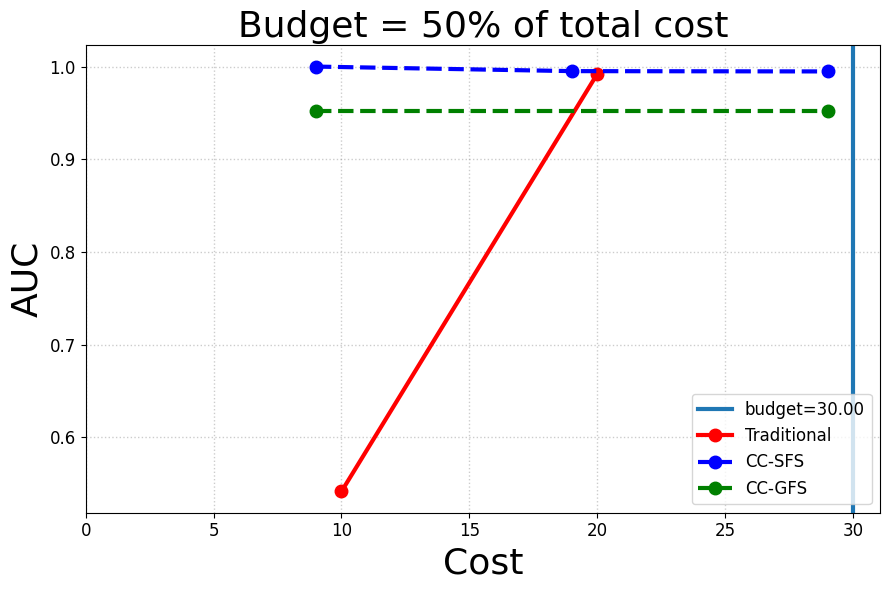

In [15]:
plot_scores(
    results_df=results_df,
    budget=30,
    total_cost=TOTAL_COST,
    plot_settings=plot_settings
)